In this notebook, we recompute various statistical values generated in an MFX GLM and compare those results with the ones generated by FEAT. Those manual recomputations use as inputs the study-level copes, the study-level varcopes and  the estimate of between-subject variance provided by FEAT (`mean_random_effects_var1.nii.gz`).

In [2]:
import nibabel as nib
import os
import numpy as np
import scipy
import pandas as pd
import scipy.stats

## T-statistic for one-sample MFX GLM

We denote the one-sample meta-analytic estimate of interest by $\gamma$, in a MFX GLM we have:
$$
\hat\gamma = \sum \kappa_i \hat\beta_i / \sum \kappa_i
$$
$$
\hat Var (\hat \gamma) = 1/ \sum \kappa_i
$$

with 
$$
\kappa_i = 1/(\sigma_i^2 + \tau^2)
$$

where:
 - $\hat\beta_i^2$ is the the contrast estimate for study $i$
 - $\sigma_i^2$ is the variance of the contrast estimate for study $i$
 - $\tau^2$ is the between-study variance

The corresponding t-statistic is:
$$
t = \hat\gamma / \sqrt(\hat Var (\hat \gamma))
$$

Under the assumption that the number of studies and samples per studies are large, we have:
$$
t \sim \mathcal T_{k-1}
$$
where $k$ is the number of studies.

In [49]:
def compute_kappas(varcopes, hat_tau):
    sum_wth_btw = varcopes + np.expand_dims(hat_tau, axis=1)
    kappa_i = 1/sum_wth_btw 
    return(kappa_i)

def compute_varcope(kappa_i):
    sum_kappa_i = np.sum(kappa_i, axis=1)
#     sum_weights = np.sum(weights[wth], axis=1)
#     print(np.isclose(sum_weights,sum_kappa_i))
#     print(np.all(np.isclose(weights[wth], kappa_i_manually)))
    varcope = 1/sum_kappa_i
    return(varcope)

def ba_plot(A, B, AisRef=False):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(10,5))
    if AisRef:
        x_data = A
    else:
        x_data = (A+B)/2
    ax2.plot(x_data, (A-B)/2, '-')
    plt.show()

def compute_cope(copes, kappa_i):
    cope = np.sum(copes*kappa_i, axis=1)/np.sum(kappa_i, axis=1)
    return(cope)

def compute_tstat(meta_cope, varcopes, hat_tau):
    # Recompute tstat manually
    kappa_i_manually = compute_kappas(varcopes, hat_tau)   
    meta_varcope_man = compute_varcope(kappa_i_manually)
    meta_t_man = meta_cope/np.sqrt(meta_varcope_man)
    return(meta_t_man)

In [32]:
compute_tstat(diff_vox0_10['cope1'], diff_vox0_10['var_filtered_func_data'], diff_vox0_10['mean_random_effect'])

array([-1.42888481, -1.26960403,  0.55215312, -1.9512955 ,  0.47544528,
        0.68620303, -1.05750572,  1.60916034,  1.7032669 ,  0.73789192])

In [34]:
print(tstats['diff'][0:10])

[-1.42888474 -1.26960397  0.55215311 -1.9512955   0.47544527  0.686203
 -1.05750573  1.6091603   1.70326686  0.73789185]


## Compare tstat, cope, varcope and weights 

### Dataset 1: Monte Carlo simulation setup
This first dataset is made of simulated data. Study level contrast estimates (denoted $\hat \beta_i$'s) and contrast variance estimates (denoted $\sigma_i$'s) were simulated according to:
$$
\hat \beta_i \sim \mathcal{N}(0, \sigma_i^2+\tau^2)
$$

$$
s^2_i \sim \chi^2_{n-1}*\frac{\sigma_i^2}{n-1}
$$

where:
 - $\tau^2=1$ is the between-study variance, 
 - $\sigma_i^2$ is the variance of contrast estimate for study i (i.e. the within-study variance divided by $n$) and 
 - $n=20$ is the number of subjects per studies.
 
6 different simulation schemes were computed:
 - 'diff': $\sigma^2_i \in \{0.25, 0.5, 1, 2, 4\}$
 - '05': $\sigma^2_i=\frac{5}{n}=0.25 \; \forall i$
 - '10': $\sigma^2_i=\frac{10}{n}=0.50 \; \forall i$
 - '20': $\sigma^2_i=\frac{20}{n}=1 \; \forall i$
 - '40': $\sigma^2_i=\frac{40}{n}=2 \; \forall i$
 - '80': $\sigma^2_i=\frac{80}{n}=4 \; \forall i$

### Load data

In [111]:
# Simulation parameters
nrep = 1; # 38 repeats are available, only looking at 1
nsimuperrep = 30*30*30
nreal = nrep*nsimuperrep # Total number of realisations

tau2 = 1 # Between-study variance
nsubjects = 20 # Number of subjects per study

varcope_sigma2 = [0.25, 0.5, 1, 2, 4]
sigma2 = dict(('{num:02d}'.format(num=int(t*nsubjects)), 
               '$\\tau^2 = 1, \sigma^2_i = ' + str(t) + '$')  
              for t in varcope_sigma2) # Possible within-study variances (constant across studies)
sigma2['diff'] = '$\\tau^2 = 1, \sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$'

kstudies = 25 # Number of studies in the meta-analysis (one-sample)
dof = kstudies - 1 # Degrees of freedom

In [112]:
# Load the data
base_dir = '/Volumes/camille/IBMA_simu/'

wth_n20 = dict()

hat_taus = {k: [] for k in sigma2.keys()} # mean_random_effects_var1.nii.gz concatenated across (independent) runs & voxels
tstats = {k: [] for k in sigma2.keys()} # tstat1.nii.gz concatenated across (independent) runs & voxels
zstats = {k: [] for k in sigma2.keys()} # zstat1.nii.gz concatenated across (independent) runs & voxels
meta_varcopes = {k: [] for k in sigma2.keys()} # varcope1.nii.gz concatenated across (independent) runs & voxels
meta_copes = {k: [] for k in sigma2.keys()} # cope1.nii.gz concatenated across (independent) runs & voxels
weights = dict() # weights.nii.gz concatenated across (independent) runs & voxels
study_varcopes = dict() # varcopes.nii.gz concatenated across (independent) runs & voxels
study_copes = dict() # varcopes.nii.gz concatenated across (independent) runs & voxels

for wth in sigma2.keys():
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=r), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 
                                       'mean_random_effects_var1.nii.gz')).get_data().flatten()
    hat_taus[wth] = np.append(hat_taus[wth], data_array)
    t_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'tstat1.nii.gz')).get_data().flatten()
    tstats[wth] = np.append(tstats[wth], t_data_array)
    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'varcope1.nii.gz')).get_data().flatten()
    meta_varcopes[wth] = np.append(meta_varcopes[wth], varcope_array)
    cope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'cope1.nii.gz')).get_data().flatten()
    meta_copes[wth] = np.append(meta_copes[wth], cope_array)

    weights_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'weights1.nii.gz')).get_data().reshape(-1,kstudies)
    if wth not in weights:
        weights[wth] = weights_array
    else:
        weights[wth] = np.append(weights[wth], weights_array, axis=0)

    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'varcope.nii.gz')).get_data().reshape(-1,kstudies)
    if wth not in study_varcopes:
        study_varcopes[wth] = varcope_array
    else:
        study_varcopes[wth] = np.append(study_varcopes[wth], varcope_array, axis=0)
        
    cope_array = nib.load(os.path.join(wth_n20[wth,r], 'cope.nii.gz')).get_data().reshape(-1,kstudies)
    if wth not in study_copes:
        study_copes[wth] = cope_array
    else:
        study_copes[wth] = np.append(study_copes[wth], cope_array, axis=0)

### Check on 10 first voxels with 'diff' settings

In [126]:
import scipy.io as sio

# diff_vox0 = dict()

# diff_vox0['var_filtered_func_data'] = study_varcopes['diff'][0,:]
# diff_vox0['filtered_func_data'] = study_copes['diff'][0,:]
# diff_vox0['weights1'] = weights['diff'][0,:]
# diff_vox0['mean_random_effect'] = hat_taus['diff'][0]
# diff_vox0['tstat1'] = tstats['diff'][0]
# diff_vox0['cope1'] = meta_copes['diff'][0]
# diff_vox0['varcope1'] = meta_varcopes['diff'][0]
# sio.savemat('ibma_simu_diff_vox0.mat', diff_vox0)
    
# import scipy.io as sio

diff_vox0_10 = dict()

diff_vox0_10['var_filtered_func_data'] = study_varcopes['diff'][0:10,:]
diff_vox0_10['filtered_func_data'] = study_copes['diff'][0:10,:]
diff_vox0_10['weights1'] = weights['diff'][0:10,:]
diff_vox0_10['mean_random_effect_var'] = hat_taus['diff'][0:10]
diff_vox0_10['tstat1'] = tstats['diff'][0:10]
diff_vox0_10['cope1'] = meta_copes['diff'][0:10]
diff_vox0_10['varcope1'] = meta_varcopes['diff'][0:10]
sio.savemat('ibma_simu_diff_vox0_10.mat', diff_vox0_10)

print('*** Compare FSL FEAT estimates with manual calculations for 10 first voxels using the \'diff\' settings')
manual = compare_fsl_with_manual(diff_vox0_10['filtered_func_data'], 
                        diff_vox0_10['var_filtered_func_data'], 
                        diff_vox0_10['mean_random_effect_var'], 
                        diff_vox0_10['weights1'], 
                        diff_vox0_10['varcope1'], 
                        diff_vox0_10['cope1'], 
                        diff_vox0_10['tstat1'])

*** Compare FSL FEAT estimates with manual calculations for 10 first voxels using the 'diff' settings
Are the tstat identical?    Yes
Are the varcope identical?  Yes
Are the cope identical?     Yes
Are the weights identical?  No! (Max error is: 1.77855563319)
[ 1.11446776  1.31200789  0.48407063  1.81136775  0.93756085  0.53883759
  0.82058556  1.05072217  0.80851234  0.70428162]
[ 2.34688067  2.77955794  1.80987203  2.88698697  1.68711901  1.52155542
  2.30729342  1.7853682   1.24046981  1.2635926 ]
(only part of the data is displayed)


### Check for all voxels

In [114]:
wth_todisp = sigma2.keys() # Settings to be displayed

In [128]:
nsettings = len(wth_todisp)

kappa_i_manually = dict()
t_manually = dict()
fsl_kappa_i = dict()
meta_varcope_man = dict()

for wth in wth_todisp:   
    print('*** Compare FSL FEAT estimates with manual calculations for all voxels using the \'' + wth + '\' settings')
    manual[wth] = compare_fsl_with_manual(study_copes[wth], 
                        study_varcopes[wth], 
                        hat_taus[wth], 
                        weights[wth], 
                        meta_varcopes[wth], 
                        meta_copes[wth], 
                        tstats[wth], 
                        atol=1 # Need to increase tolerance for tstat with 'diff' settings
                       )
    print('\n')

*** Compare FSL FEAT estimates with manual calculations for all voxels using the '05' settings
Are the tstat identical?    Yes
Are the varcope identical?  Yes
Are the cope identical?     Yes
Are the weights identical?  No! (Max error is: 5.90550366525)
[ 1.06307363  1.05060417  0.54443311  1.71380254  1.00496164  0.69907507
  0.75720791  1.01916568  0.88933239  0.83872486]
[ 1.14026082  0.97389722  0.8993904   1.09609485  1.03373647  1.02024209
  0.97833437  0.9408226   0.91181892  0.96821398]
(only part of the data is displayed)


*** Compare FSL FEAT estimates with manual calculations for all voxels using the '10' settings
Are the tstat identical?    Yes
Are the varcope identical?  Yes
Are the cope identical?     Yes
Are the weights identical?  No! (Max error is: 3.90204878214)
[ 0.97104161  0.85208185  0.42500321  1.51041137  0.84604776  0.58928635
  0.6148951   0.81125721  0.68904309  0.67817483]
[ 1.24985588  0.94784337  0.84251422  1.15921462  1.0443269   1.03201759
  0.95335448 

Conclusion: The T-statistic (`tstat1`), the meta-analytic estimate (`cope1`) and its variance estimate (`varcope1)` can be reproduced but the weights are different.

### Investigate how the weights are different

In [186]:
import pandas as pd

mean_weights_by_study_man = dict()
mean_weights_by_study_fsl = dict()
for wth in wth_todisp:
    mean_weights_by_study_man[wth] = np.mean(manual[wth]['kappa_i'], axis=0)
    mean_weights_by_study_fsl[wth] = np.mean(weights[wth], axis=0)

mean_weights_by_study_man = pd.DataFrame.from_dict(mean_weights_by_study_man)
mean_weights_by_study_fsl = pd.DataFrame.from_dict(mean_weights_by_study_fsl)

In [202]:
weights_100vox = dict()
weights_100vox_man = dict()
for wth in wth_todisp:
    weights_100vox[wth] = weights[wth][1:100,:].flatten()
    weights_100vox_man[wth] = manual[wth]['kappa_i'][1:100,:].flatten()
    
weights_100vox = pd.DataFrame.from_dict(weights_100vox)
weights_100vox_man = pd.DataFrame.from_dict(weights_100vox_man)

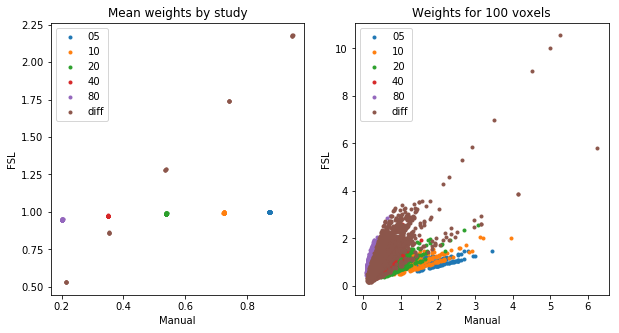

In [208]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,5))
my_lines = ax1.plot(mean_weights_by_study_man, mean_weights_by_study_fsl, '.')
ax1.legend(my_lines, list(mean_weights_by_study_fsl.columns.values), loc='upper left')
ax1.set_title('Mean weights by study')
ax1.set_xlabel('Manual')
ax1.set_ylabel('FSL')

num_vox = 100
ax2.plot(weights_100vox_man, weights_100vox, '.')
ax2.set_title('Weights for 100 voxels')
ax2.legend(my_lines, list(weights_100vox_man.columns.values), loc='upper left')
ax2.set_xlabel('Manual')
ax2.set_ylabel('FSL')

plt.show()

### Dataset 1: Monte Carlo simulation setup

In [228]:
happy=dict()

happy['k'] = 6 # number of susbjects

happy['path'] = '/Users/cmaumet/Downloads/HappyFaces_3-9.gfeat/cope1.feat'
happy['copes'] = nib.load(os.path.join(happy['path'], 'filtered_func_data.nii.gz')).get_data().reshape((-1, happy['k']))
happy['varcopes'] = nib.load(os.path.join(happy['path'], 'var_filtered_func_data.nii.gz')).get_data().reshape((-1, happy['k']))
happy['meta_varcope'] = nib.load(os.path.join(happy['path'], 'stats', 'varcope1.nii.gz')).get_data().flatten()
happy['meta_cope'] = nib.load(os.path.join(happy['path'], 'stats', 'cope1.nii.gz')).get_data().flatten()
happy['weights'] = nib.load(os.path.join(happy['path'], 'stats', 'weights1.nii.gz')).get_data().reshape((-1, happy['k']))
happy['mask'] = nib.load(os.path.join(happy['path'], 'mask.nii.gz')).get_data().flatten()
happy['tstat'] = nib.load(os.path.join(happy['path'], 'stats', 'tstat1.nii.gz')).get_data().flatten()
happy['hat_tau'] = nib.load(os.path.join(happy['path'], 'stats', 'mean_random_effects_var1.nii.gz')).get_data().flatten()

In [255]:
def compare_man_fsl(title, x_man, x_fsl, mask, **kwargs):
    print(x_man.shape)    
    if mask is not None:
        print('masking')
        to_keep = np.logical_and(
            np.logical_and(mask,
                           )),
            np.logical_not(np.isnan(x_fsl)))
        if len(x_man.shape) > 1:
            x_man = x_man[to_keep,:]
            x_fsl = x_fsl[to_keep,:]
        else:
            x_man = x_man[to_keep]
            x_fsl = x_fsl[to_keep]
    print(x_man.shape)    
    print(title, end=" ")
    are_close = np.allclose(x_man, x_fsl, **kwargs)
    if not are_close:
        print('No! (Max error is: ' + str(np.max(np.abs(x_man-x_fsl))) + ')')
        if len(x_man.shape) > 1:           
            not_nan_man = np.logical_not(np.any(np.isnan(x_man), axis=1))
            not_nan_fsl = np.logical_not(np.any(np.isnan(x_man), axis=1))
            
            print(x_man[range(10),0])
            print(x_fsl[range(10),0])
            print('(only part of the data is displayed)')
        else:
            print(x_man)
            print(x_fsl)

    else:
        print('Yes')

def compare_fsl_with_manual(copes, varcopes, hat_tau, fsl_kappa_i, fsl_varcope, fsl_cope, fsl_tstat,
                            mask=None, disp=True, **kwargs):
    kappa_i_man = compute_kappas(varcopes, hat_tau)
    varcope_man = compute_varcope(kappa_i_man)
    cope_man = compute_cope(copes, kappa_i_man)
    tstat_man = compute_tstat(cope_man, varcopes, hat_tau)
    
    if disp:
        compare_man_fsl('Are the tstat identical?   ', tstat_man, fsl_tstat, mask, **kwargs)
        compare_man_fsl('Are the varcope identical? ', varcope_man, fsl_varcope, mask, **kwargs)
        compare_man_fsl('Are the cope identical?    ', cope_man, fsl_cope, mask, **kwargs)
        compare_man_fsl('Are the weights identical? ', kappa_i_man, fsl_kappa_i, mask, **kwargs)
    
    return({'kappa_i': kappa_i_man, 'varcope': varcope_man, 'cope': cope_man, 'tstat': tstat_man})

In [254]:
sum(not happy['mask']>0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [256]:
happy_manual = compare_fsl_with_manual(happy['copes'], 
                        happy['varcopes'], 
                        happy['hat_tau'], 
                        happy['weights'], 
                        happy['meta_varcope'], 
                        happy['meta_cope'], 
                        happy['tstat'],
                        happy['mask'])

(902629,)
masking
(254951,)
Are the tstat identical?    No! (Max error is: 7.15256e-07)
[ 0.00961896  0.116971   -0.05768658 ..., -0.34574014 -0.25881475
 -0.50365531]
[ 0.00961895  0.11697099 -0.05768656 ..., -0.34574017 -0.25881469
 -0.50365537]
(902629,)
masking
(267926,)
Are the varcope identical?  Yes
(902629,)
masking
(254951,)
Are the cope identical?     No! (Max error is: 0.000488281)
[  0.11514574   6.73433638  -1.45770001 ..., -32.53580856 -21.69360161
 -57.10350037]
[  0.1151457    6.73433542  -1.45769954 ..., -32.53581238 -21.69359779
 -57.10350037]
(902629, 6)
masking


/Users/cmaumet/anaconda/envs/r-env/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/cmaumet/anaconda/envs/r-env/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in multiply


ValueError: operands could not be broadcast together with shapes (902629,) (902629,6) 